# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- *Your names here*

**If you wish to present any of the tasks, please tell us here.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [3]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [4]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        
        # Your initialization code comes here.
        self.W = nn.Parameter(torch.from_numpy(np.random.normal(size=(in_features, out_features))).float())
        if bias:
            self.b = nn.Parameter(torch.from_numpy(np.random.normal(size=(out_features,))).float())
        else:
            self.b = nn.Parameter(torch.from_numpy(np.zeros((out_features,))).float(), requires_grad=False)
            
    def forward(self, X):
        # The forward pass of the linear regression comes here.
        return X @ self.W + self.b


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [5]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features, bias=False)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear
Epoch 1/25 - Loss: 31.551811933517456
Epoch 2/25 - Loss: 20.4591703414917
Epoch 3/25 - Loss: 16.64627343416214
Epoch 4/25 - Loss: 15.515215754508972
Epoch 5/25 - Loss: 14.579948008060455
Epoch 6/25 - Loss: 13.658727884292603
Epoch 7/25 - Loss: 13.082401931285858
Epoch 8/25 - Loss: 12.398196041584015
Epoch 9/25 - Loss: 11.961072385311127
Epoch 10/25 - Loss: 11.578779369592667
Epoch 11/25 - Loss: 11.19524484872818
Epoch 12/25 - Loss: 10.756310999393463
Epoch 13/25 - Loss: 10.541553169488907
Epoch 14/25 - Loss: 10.093727350234985
Epoch 15/25 - Loss: 9.918684095144272
Epoch 16/25 - Loss: 9.626674205064774
Epoch 17/25 - Loss: 9.482364118099213
Epoch 18/25 - Loss: 9.309733211994171
Epoch 19/25 - Loss: 9.071949034929276
Epoch 20/25 - Loss: 9.112712502479553
Epoch 21/25 - Loss: 8.876394361257553
Epoch 22/25 - Loss: 8.751980543136597
Epoch 23/25 - Loss: 8.647521138191223
Epoch 24/25 - Loss: 8.64259421825409
Epoch 25/25 - Loss: 8.293541371822357
Test MSE: 0.5008386972317124

torch.nn.Li

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [6]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


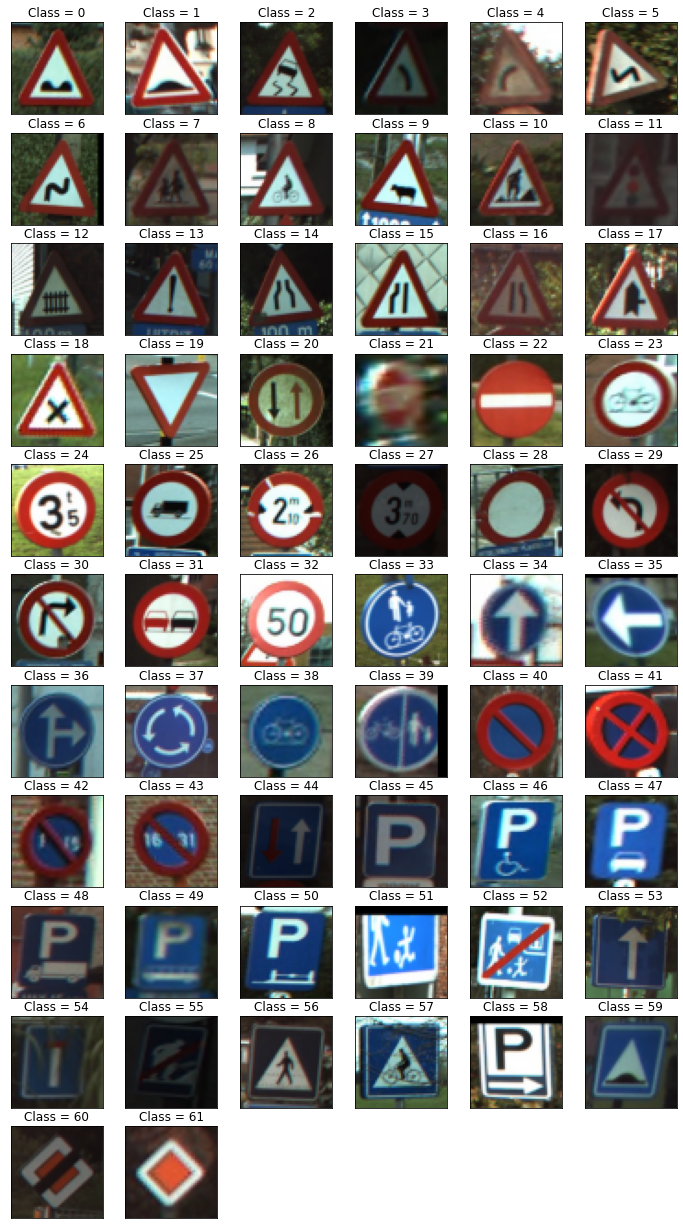

In [7]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [8]:
# Implement your model and training here.
in_features = 50 * 50 * 3
out_features = 62
hidden_dim = 512
# I will run it on GPU.
device = torch.device('cuda')  # Replace 'cuda' with 'cpu' to on CPU instead.

fnn = nn.Sequential(
    nn.Linear(in_features, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, out_features)
).to(device)

fnn

Sequential(
  (0): Linear(in_features=7500, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=62, bias=True)
)

In [9]:
def train_image_classifier(model, dataset, learning_rate, batch_size, epochs, device): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0 

        for batch in data_loader:
            model.zero_grad()
            model.zero_grad()

            yhat = model.forward(batch['X'].float().to(device))

            batch_loss = F.cross_entropy(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item()
            
            batch_loss.backward()
            optimizer.step()
        
        if (epoch == 0) or (((epoch + 1) % 50) == 0):
            print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')
        

learning_rate = 0.005
batch_size = 256
epochs = 250

dataset = FlattenedImageDataset(X_train, y_train)
train_image_classifier(fnn, dataset, learning_rate, batch_size, epochs, device)

Epoch 1/250 - Loss: 83.56820869445801
Epoch 50/250 - Loss: 0.36137280240654945
Epoch 100/250 - Loss: 0.003400621935725212
Epoch 150/250 - Loss: 0.0008674338459968567
Epoch 200/250 - Loss: 0.000389760360121727
Epoch 250/250 - Loss: 0.00019595026969909668


In [10]:
# Implement your evaluation here.
from sklearn.metrics import precision_recall_fscore_support

dataset_test = FlattenedImageDataset(X_test, y_test)

with torch.no_grad():
    X = torch.from_numpy(np.array([sample['X'] for sample in dataset_test])).float().to(device)
    yhat_unnormalized = fnn.forward(X).detach().cpu().numpy()
    
yhat = np.argmax(yhat_unnormalized, axis=1)
y = np.array([sample['y'] for sample in dataset_test])
prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average='weighted')

print(f'Precision: {prec:.03}')
print(f'Recall: {rec:.03}')
print(f'F1-score: {f1:.03}')

Precision: 0.918
Recall: 0.885
F1-score: 0.892


/home/baierax/PycharmProjects/sandbox/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/baierax/PycharmProjects/sandbox/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


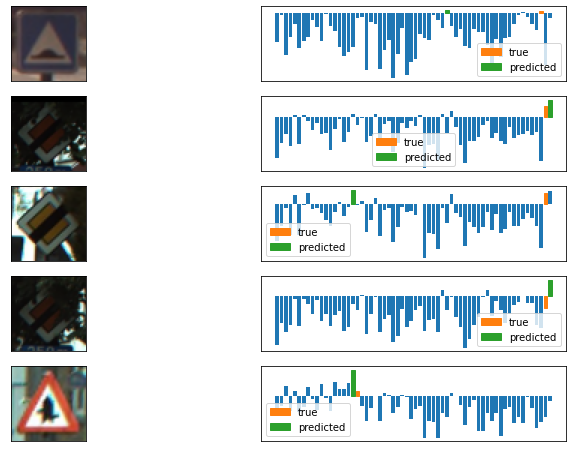

In [11]:
misclassified_idx = np.where(y != yhat)[0]

fig, ax = plt.subplots(5, 2, figsize=(12, 8))
for i in range(5):
    idx = misclassified_idx[i]
    ax[i, 0].imshow(X_test[idx])
    bars = ax[i, 1].bar(np.arange(0, out_features), yhat_unnormalized[idx], color='C0')
    bars[y_test[idx]].set_color('C1')
    bars[yhat[idx]].set_color('C2')
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    
    ax[i, 1].legend([bars[y_test[idx]], bars[yhat[idx]]], ['true', 'predicted'])

## Task 3: Image Classification with CNN

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [12]:
# Implement your model and training here.
class ImageDataset(object):
    def __init__(self, X, y):
        self.X = np.moveaxis(X, -1, 1)
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # I took the architecture from this CIFAR tutorial and only adjusted the width of the linear layer.
        # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # You can figure out this number by printing the shape of the previous layer.
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 62)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) to figure out the size of your linear layer
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
cnn = CNN().to(device)

dataset = ImageDataset(X_train, y_train)

learning_rate = 0.005
batch_size = 256
epochs = 250
train_image_classifier(cnn, dataset, learning_rate, batch_size, epochs, device)

Epoch 1/250 - Loss: 64.00387620925903
Epoch 50/250 - Loss: 0.05755998380482197
Epoch 100/250 - Loss: 0.0005339980125427246
Epoch 150/250 - Loss: 0.00019272230565547943
Epoch 200/250 - Loss: 0.00011087395250797272
Epoch 250/250 - Loss: 6.03795051574707e-05


In [13]:
from sklearn.metrics import precision_recall_fscore_support

dataset_test = ImageDataset(X_test, y_test)

with torch.no_grad():
    X = torch.from_numpy(np.array([sample['X'] for sample in dataset_test])).float().to(device)
    yhat_unnormalized = cnn.forward(X).detach().cpu().numpy()
    
yhat = np.argmax(yhat_unnormalized, axis=1)
y = np.array([sample['y'] for sample in dataset_test])
prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average='weighted')

print(f'Precision: {prec:.03}')
print(f'Recall: {rec:.03}')
print(f'F1-score: {f1:.03}')

Precision: 0.949
Recall: 0.94
F1-score: 0.943
